In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

things that still need to be done:
    - add filepaths and location names for the remaining locations when they finish
    - stratify by age group if time
    - stratify by malnourishment if time

In [2]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
#fig, ax = plt.subplots(1,1)
#x = np.linspace(loc, loc+(120-50), 200)
#ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
#plt.show()

In [3]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/',
                '/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/pakistan/2020_02_06_17_38_45/count_data/']

locations = ['India',
            'Pakistan']

In [4]:
master_avg = pd.DataFrame()
master_draws = pd.DataFrame()

for i in list(range(0,2)):
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    ylds = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])

    # add cost data
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] / dalys_baseline['total_population'] * 100_000
    dalys_baseline['dalys'] = dalys_baseline['dalys'] / dalys_baseline['total_population'] * 100_000
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] / dalys_mmn['total_population'] * 100_000
    dalys_mmn['dalys'] = dalys_mmn['dalys'] / dalys_mmn['total_population'] * 100_000
    dalys_mmn = dalys_mmn.drop(columns='person_time')

    dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
    dalys_bep['cost'] = dalys_bep['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep['person_time'])) / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_avg'] = 60.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_low'] = 51.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['cost_bep_high'] = 120.42 * dalys_bep['bep_population'] / dalys_bep['total_population'] * 100_000
    dalys_bep['dalys'] = dalys_bep['dalys'] / dalys_bep['total_population'] * 100_000
    dalys_bep = dalys_bep.drop(columns='person_time')
    
    dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna().drop(columns='scenario'))
    dalys_bep_targeted['cost'] = (dalys_bep_targeted['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_targeted['person_time'])) 
                                   + dalys_bep_targeted['mmn_population'] * 3.69) / dalys_bep_targeted['total_population'] * 100_000   
    dalys_bep_targeted['cost_bep_targeted_avg'] = (60.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69)  / dalys_bep_targeted['total_population'] * 100_000  
    dalys_bep_targeted['cost_bep_targeted_low'] = (51.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) / dalys_bep_targeted['total_population'] * 100_000  
    dalys_bep_targeted['cost_bep_targeted_high'] = (120.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) / dalys_bep_targeted['total_population'] * 100_000  
    dalys_bep_targeted['dalys'] = dalys_bep_targeted['dalys'] / dalys_bep_targeted['total_population'] * 100_000
    dalys_bep_targeted = dalys_bep_targeted.drop(columns='person_time')
    
    dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_mmn'])
    dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
    dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
    dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
    
    #dalys_scenarios['cost_averted_bep_avg'] = dalys_scenarios['cost_bep_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_low'] = dalys_scenarios['cost_bep_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_high'] = dalys_scenarios['cost_bep_high'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_low'] = dalys_scenarios['cost_bep_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_high'] = dalys_scenarios['cost_bep_targeted_high'] - dalys_scenarios['cost_baseline']

    dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_bep']

    
    dalys_scenarios['icer_mmn'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
    dalys_scenarios['icer_bep'] = dalys_scenarios['cost_averted_bep'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_low'] = dalys_scenarios['cost_averted_bep_low'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_high'] = dalys_scenarios['cost_averted_bep_high'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted_low'] = dalys_scenarios['cost_averted_bep_targeted_low'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted_high'] = dalys_scenarios['cost_averted_bep_targeted_high'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
    
    dalys_scenarios['icer_bep_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep']
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    
    dalys_scenarios['location'] = locations[i]
    master_draws = master_draws.append(dalys_scenarios.reset_index())
        
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time'])
    dalys_mean = pd.DataFrame(dalys_prep.mean())
    dalys_min = pd.DataFrame(dalys_prep.min())
    dalys_max = pd.DataFrame(dalys_prep.max())
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True, suffixes=['_mean','_min'])
    per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True, suffixes=['_mean','_max'])
    final_per_pt = per_pt1.merge(per_pt2, right_index=True, left_index=True, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={'0_mean':'mean', '0_min':'min', '0_max':'max'}).drop(columns='0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    final_per_pt['location'] = locations[i]
    master_avg = master_avg.append(final_per_pt)

master_avg.head()
    

,index,mean,min,max,location
0,dalys_baseline,467731.973955,405560,528031,India
1,total_population_baseline,100000.000000,100000,100000,India
2,bep_population_baseline,0.000000,0,0,India
3,ifa_population_baseline,34031.680000,30285,39883,India
4,mmn_population_baseline,0.000000,0,0,India


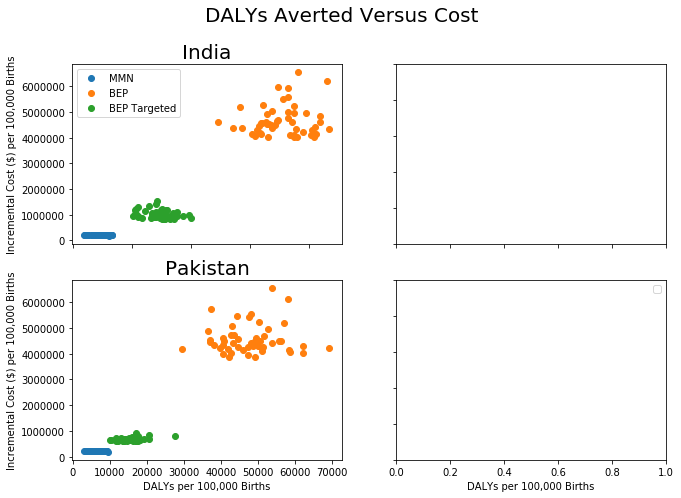

In [5]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
#mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
#tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

axs[0,0].scatter(india['dalys_averted_mmn']*(-1),india['cost_averted_mmn'])
axs[0,0].scatter(india['dalys_averted_bep']*(-1),india['cost_averted_bep'])
axs[0,0].scatter(india['dalys_averted_bep_targeted']*(-1),india['cost_averted_bep_targeted'])
axs[0,0].legend(['MMN','BEP','BEP Targeted'])
axs[0,0].set_title('India',fontsize=20)

#axs[0,1].scatter(mali['dalys_averted_mmn']*(-1),mali['cost_averted_mmn'])
#axs[0,1].scatter(mali['dalys_averted_bep']*(-1),mali['cost_averted_bep'])
#axs[0,1].scatter(mali['dalys_averted_bep_targeted']*(-1),mali['cost_averted_bep_targeted'])
#axs[0,1].set_title('Mali',fontsize=20)

axs[1,0].scatter(pakistan['dalys_averted_mmn']*(-1),pakistan['cost_averted_mmn'])
axs[1,0].scatter(pakistan['dalys_averted_bep']*(-1),pakistan['cost_averted_bep'])
axs[1,0].scatter(pakistan['dalys_averted_bep_targeted']*(-1),pakistan['cost_averted_bep_targeted'])
axs[1,0].set_title('Pakistan',fontsize=20)

#axs[1,1].scatter(tanzania['dalys_averted_mmn']*(-1),tanzania['cost_averted_mmn'])
#axs[1,1].scatter(tanzania['dalys_averted_bep']*(-1),tanzania['cost_averted_bep'])
#axs[1,1].scatter(tanzania['dalys_averted_bep_targeted']*(-1),tanzania['cost_averted_bep_targeted'])
#axs[1,1].set_title('Tanzania',fontsize=20)

for ax in axs.flat:
    ax.set(xlabel='DALYs per 100,000 Births', ylabel='Incremental Cost ($) per 100,000 Births')
    ax.label_outer()

plt.legend(['MMN','BEP','BEP Targeted'])
plt.suptitle('DALYs Averted Versus Cost',x=0.75,y=1.7,fontsize=20)
plt.subplots_adjust(right=1.5, top=1.5)

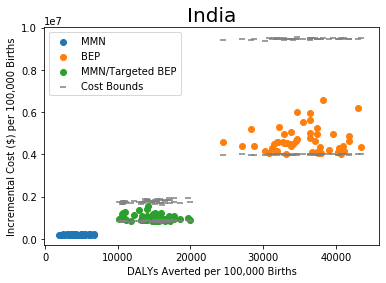

In [6]:
plt.scatter(india['dalys_averted_mmn']*(-1),india['cost_averted_mmn'])
plt.scatter(india['dalys_averted_bep']*(-1),india['cost_averted_bep'])
plt.scatter(india['dalys_averted_bep_targeted']*(-1),india['cost_averted_bep_targeted'])

plt.scatter(india['dalys_averted_bep']*(-1),india['cost_averted_bep_low'],marker='_',c='grey')
plt.scatter(india['dalys_averted_bep']*(-1),india['cost_averted_bep_high'],marker='_',c='grey')
plt.scatter(india['dalys_averted_bep_targeted']*(-1),india['cost_averted_bep_targeted_low'],marker='_',c='grey')
plt.scatter(india['dalys_averted_bep_targeted']*(-1),india['cost_averted_bep_targeted_high'],marker='_',c='grey')

#plt.yscale('log')
plt.title('India',fontsize=20)
plt.ylabel('Incremental Cost ($) per 100,000 Births')
plt.xlabel('DALYs Averted per 100,000 Births')
plt.legend(['MMN','BEP','MMN/Targeted BEP','Cost Bounds'])

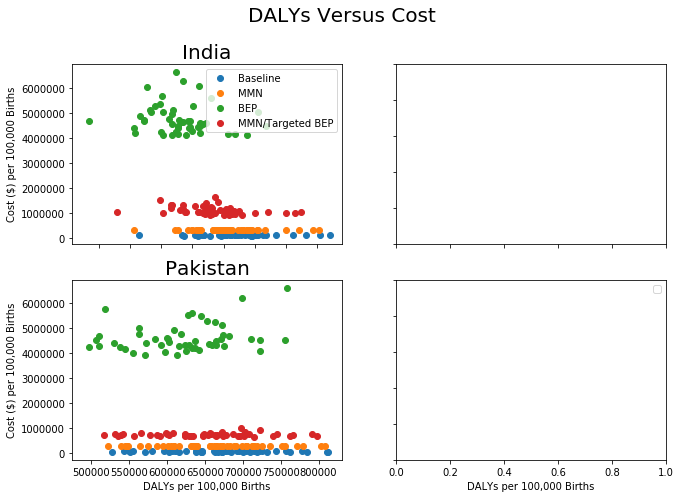

In [14]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
#mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
#tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

axs[0,0].scatter(india['dalys_baseline'],india['cost_baseline'])
axs[0,0].scatter(india['dalys_mmn'],india['cost_mmn'])
axs[0,0].scatter(india['dalys_bep'],india['cost_bep'])
axs[0,0].scatter(india['dalys_bep_targeted'],india['cost_bep_targeted'])
axs[0,0].legend(['Baseline','MMN','BEP','MMN/Targeted BEP'])
axs[0,0].set_title('India',fontsize=20)

#axs[0,1].scatter(mali['dalys_baseline'],mali['cost_baseline'])
#axs[0,1].scatter(mali['dalys_mmn'],mali['cost_mmn'])
#axs[0,1].scatter(mali['dalys_bep'],mali['cost_bep'])
#axs[0,1].scatter(mali['dalys_bep_tageted'],mali['cost_bep_targeted'])
#axs[0,1].set_title('Mali',fontsize=20)

axs[1,0].scatter(pakistan['dalys_baseline'],pakistan['cost_baseline'])
axs[1,0].scatter(pakistan['dalys_mmn'],pakistan['cost_mmn'])
axs[1,0].scatter(pakistan['dalys_bep'],pakistan['cost_bep'])
axs[1,0].scatter(pakistan['dalys_bep_targeted'],pakistan['cost_bep_targeted'])
axs[1,0].set_title('Pakistan',fontsize=20)

#axs[1,1].scatter(tanzania['dalys_baseline'],tanzania['cost_baseline'])
#axs[1,1].scatter(tanzania['dalys_mmn'],tanzania['cost_mmn'])
#axs[1,1].scatter(tanzania['dalys_bep'],tanzania['cost_bep'])
#axs[1,1].scatter(tanzania['dalys_bep_targeted'],tanzania['cost_bep_targeted'])
#axs[1,1].set_title('Tanzania',fontsize=20)

for ax in axs.flat:
    ax.set(xlabel='DALYs per 100,000 Births', ylabel='Cost ($) per 100,000 Births')
    ax.label_outer()

plt.legend(['Baseline','MMN','BEP','MMN/Targeted BEP'])
plt.suptitle('DALYs Versus Cost',x=0.75,y=1.7,fontsize=20)
plt.subplots_adjust(right=1.5, top=1.5)

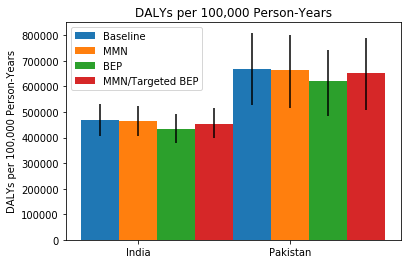

In [10]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.25

# bar heights
baseline = master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna()
baseline_upper =  master_avg['max'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna()
baseline_lower =  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_baseline').dropna()

mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_mmn').dropna()

bep = master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna()
bep_upper =  master_avg['max'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna()
bep_lower =  master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep').dropna()

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna()
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna()
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_targeted').dropna()


# bar positions
baseline_x = np.arange(len(baseline)) 
mmn_x = [x + barWidth for x in baseline_x]
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(baseline_x, baseline, yerr=[baseline_upper, baseline_lower], width=barWidth)
plt.bar(mmn_x, mmn, yerr=[mmn_upper, mmn_lower], width=barWidth)
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())
plt.ylabel('DALYs per 100,000 Person-Years')
plt.title('DALYs per 100,000 Person-Years')
plt.legend(['Baseline','MMN','BEP','MMN/Targeted BEP'])

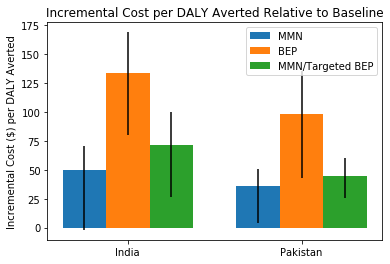

In [11]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna()*(-1)
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna()*(-1)
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))

#bep_low = master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)

#bep_targeted_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)

# bar positions
mmn_x = np.arange(len(mmn)) 
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(mmn_x, mmn, yerr=[mmn_upper, mmn_lower], width=barWidth)
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Baseline')
plt.legend(['MMN','BEP','MMN/Targeted BEP'])

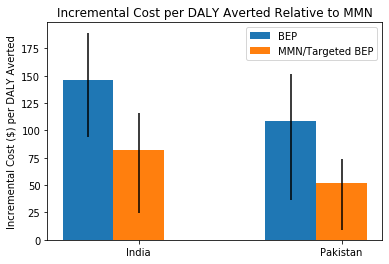

In [12]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)

# bar positions
bep_x = np.arange(len(bep)) 
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(bep))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to MMN')
plt.legend(['BEP','MMN/Targeted BEP'])

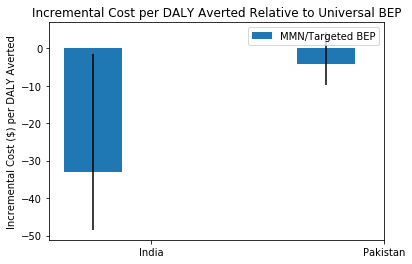

In [13]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)

# bar positions
bep_targeted_x = np.arange(len(bep_targeted)) 

# plot
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(bep_targeted))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Universal BEP')
plt.legend(['MMN/Targeted BEP'])